## Dataset Au-Au: ponta de ouro e substrato de ouro
### Teste 11 - 3x3, `honeycomb`, 100 séries temporais.
### Importando bibliotecas e dados

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matrixprofile import matrixProfile, motifs
from pyclustering.nnet.som import type_conn
import math
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

In [2]:
D3011_data = np.load('dataset_TipAu_Au.npz')

In [3]:
D3011_data.keys()

KeysView(NpzFile 'dataset_TipAu_Au.npz' with keys: smoothedMeasuredHeight_m, vDeflection_N, height_m, measuredHeight_m, seriesTime_s...)

In [4]:
list(D3011_data.keys())

['smoothedMeasuredHeight_m',
 'vDeflection_N',
 'height_m',
 'measuredHeight_m',
 'seriesTime_s',
 'time_s']

In [5]:
force_data = D3011_data['vDeflection_N']

In [6]:
force_data.shape

(1024, 800)

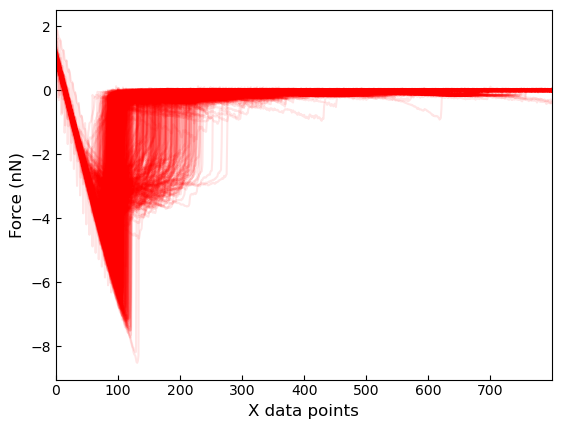

In [7]:
fig,ax = plt.subplots(dpi=100)

for curve in force_data:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Split dos dados

Para essa clusterização, foram selecionados as **primeiras 100 curvas** do *dataset*.

In [8]:
train_set = force_data[:100]
test_set = force_data[100:]

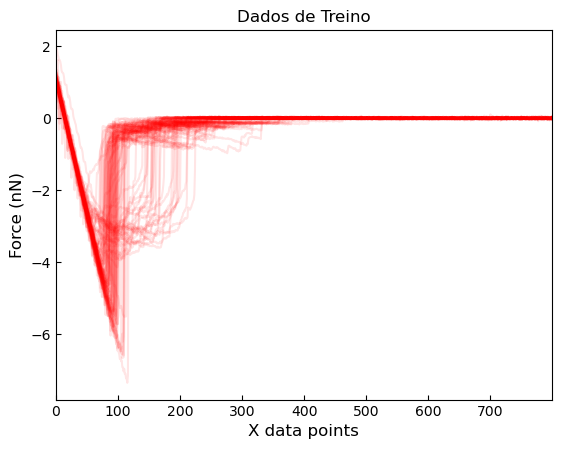

In [9]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

ax.set_title("Dados de Treino")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

In [10]:
len(train_set[0])

800

### Concatenando os dados e descobrindo motifs
Todas as curvas foram concatenadas em uma única série temporal, como indicado no artigo de base, do desenvolvimento do método DTW-SOM.

In [13]:
size = len(train_set[0])
sample_size = len(train_set)
print(size, sample_size)

800 100


In [14]:
joined_data = train_set[0]
for i in range(1, sample_size):
    joined_data = np.concatenate((joined_data, train_set[i]))
len(joined_data)

80000

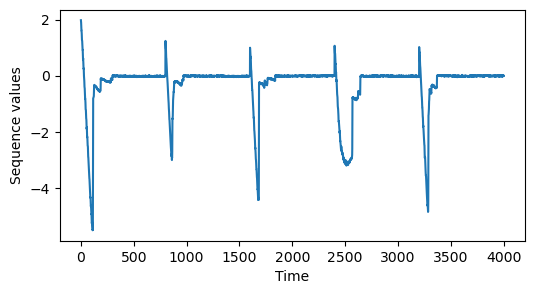

In [15]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(4000), joined_data[:4000])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

In [16]:
%%time
mp = matrixProfile.stomp(joined_data, size)

CPU times: user 46.4 s, sys: 6.91 s, total: 53.3 s
Wall time: 53.3 s


In [17]:
print(mp[1])

[23987. 23988. 23989. ... 51997. 51998. 51999.]


Somando uma matriz de zeros à matriz de perfil, assim, os valores de `Nan` se tornam numéricos e iguais a zero.

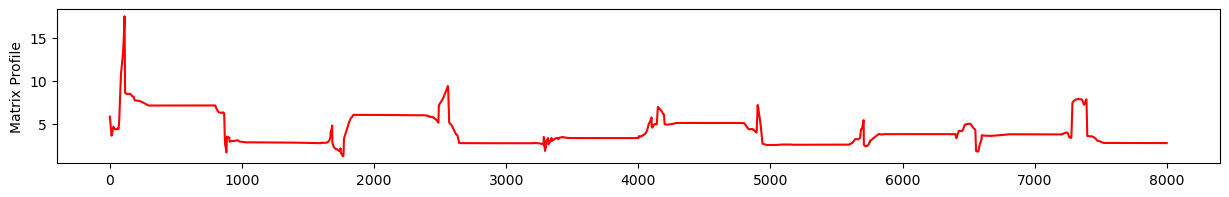

In [18]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(8000), mp_adj[:8000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extraindo os motifs.

In [19]:
%%time
mtfs, motif_d  = motifs.motifs(joined_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 152 ms, sys: 91.9 ms, total: 244 ms
Wall time: 243 ms


38

Criando uma lista com os centros de motifs.

In [20]:
motif_center_list = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center = joined_data[center_pointers]
    motif_center_list.append(motif_center)

len(joined_data)

80000

In [21]:
len(motif_center_list)

38

### Treinando a rede DTW-SOM

In [22]:
%time
rows = 3
cols = 3
structure = type_conn.honeycomb
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.34 µs


In [23]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 3.9025
Epoch 2 achieved an average quantization error of 3.9628
Epoch 3 achieved an average quantization error of 4.7274
Epoch 4 achieved an average quantization error of 4.8551
Epoch 5 achieved an average quantization error of 4.8699
Epoch 6 achieved an average quantization error of 4.9848
Epoch 7 achieved an average quantization error of 5.0035
Epoch 8 achieved an average quantization error of 4.985
Epoch 9 achieved an average quantization error of 4.9695
Epoch 10 achieved an average quantization error of 4.9455
Epoch 11 achieved an average quantization error of 4.909
Epoch 12 achieved an average quantization error of 4.8892
Epoch 13 achieved an average quantization error of 4.8723
Epoch 14 achieved an average quantization error of 4.8437
Epoch 15 achieved an average quantization error of 4.8262
Epoch 16 achieved an average quantization error of 4.8082
Epoch 17 achieved an average quantization error of 4.793
Epoch 18 achieved an avera

KeyboardInterrupt: 

### Resultados

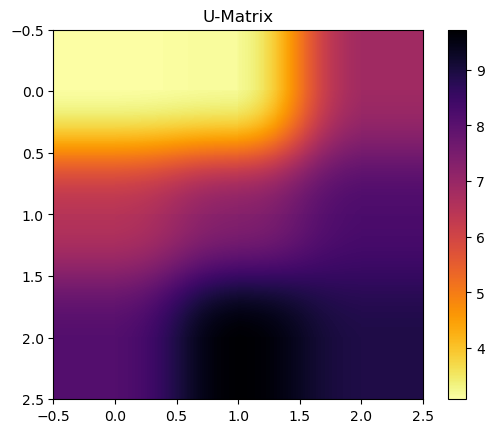

In [32]:
network.show_distance_matrix()

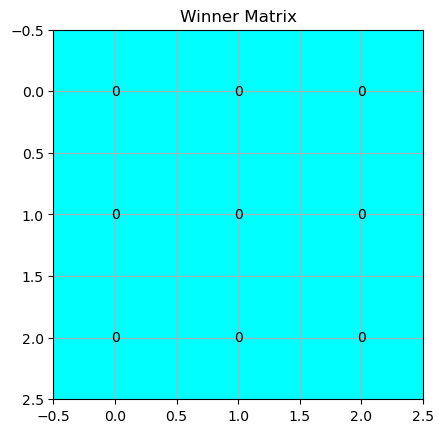

In [33]:
network.show_winner_matrix()

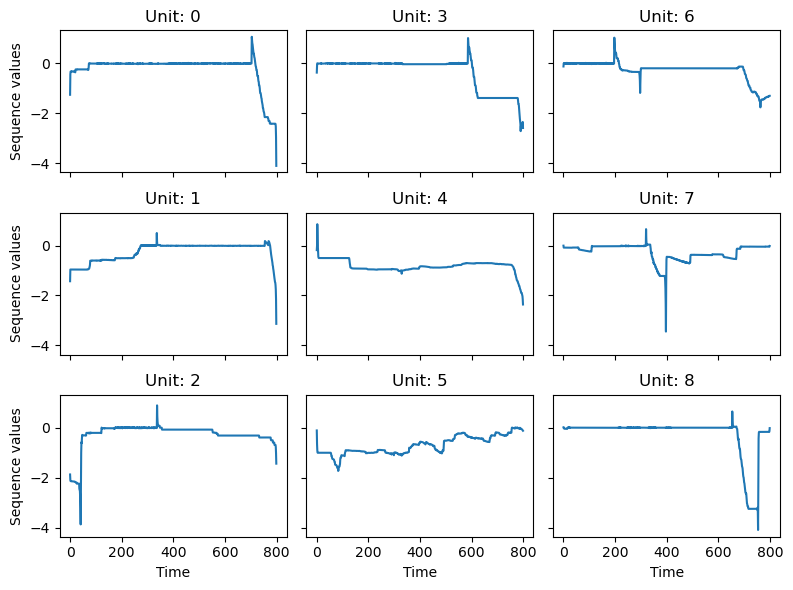

In [34]:
n_neurons = network._size
fig, axs = plt.subplots(3,3,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/3) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 3
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()